### Step 0: load the data

In [12]:
import pandas as pd
import json



df_letters = pd.read_csv('data/letters_with_opium_and_spices.tsv',sep='\t').dropna(subset=['year']).astype({'year':'int',
                                                                                                   'month':'int',
                                                                                                   'day':'int'})

In [13]:
from datetime import date

df_letters['date'] = df_letters.apply(lambda x: date(year = x['year'], month = x['month'], day = x['day']), axis=1)
df_commodities_per_date_raw = df_letters[['date','commodity_labels']]
df_commodities_per_date = df_commodities_per_date_raw[df_commodities_per_date_raw['commodity_labels'] != '{}']
df_commodities_per_date['label'] = df_commodities_per_date['commodity_labels'].map(lambda x: list(json.loads(x).keys()))
df_commodities_per_date.drop_duplicates(subset=['date','commodity_labels'], inplace=True)
df_commodities_per_date_flat = df_commodities_per_date.explode('label')
df_commodities_per_date_flat

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,commodity_labels,label
14,1614-01-01,"{""peper"": [""peper""]}",peper
23,1615-10-26,"{""peper"": [""peper""]}",peper
27,1617-05-10,"{""foelie"": [""foelie""]}",foelie
31,1617-12-17,"{""peper"": [""peper""]}",peper
33,1618-05-07,"{""nootmuskaat"": [""muskaat""], ""foelie"": [""foeli...",nootmuskaat
...,...,...,...
597,1764-05-08,"{""kaneel"": [""kaneel""], ""nootmuskaat"": [""nootmu...",opium
597,1764-05-08,"{""kaneel"": [""kaneel""], ""nootmuskaat"": [""nootmu...",peper
603,1766-04-08,"{""kaneel"": [""kaneel""], ""opium"": [""opium""], ""pe...",kaneel
603,1766-04-08,"{""kaneel"": [""kaneel""], ""opium"": [""opium""], ""pe...",opium


### Step 1: prepare the timeline

In [14]:
import datetime

all_dates = sorted(set(df_commodities_per_date['date'].tolist()))

In [15]:
first_date, last_date = all_dates[0], all_dates[-1]

In [16]:
delta = last_date-first_date
delta

datetime.timedelta(55614)

In [35]:
from tqdm.auto import tqdm
all_commodities = sorted(set(df_commodities_per_date_flat['label'].tolist()))
appearances = {}
for commodity in tqdm(all_commodities):
    df_target = df_commodities_per_date_flat[df_commodities_per_date_flat['label']==commodity]
    dates_appeared = df_target['date'].tolist()
    appearances[commodity] = []
    for num_days in range(delta.days):
        date = first_date + datetime.timedelta(num_days)
        if date in dates_appeared:
            appearances[commodity].append(num_days)
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
all_commodities

['foelie', 'kaneel', 'nootmuskaat', 'opium', 'peper']

### Step 2: plot opium vs main spices for our case study

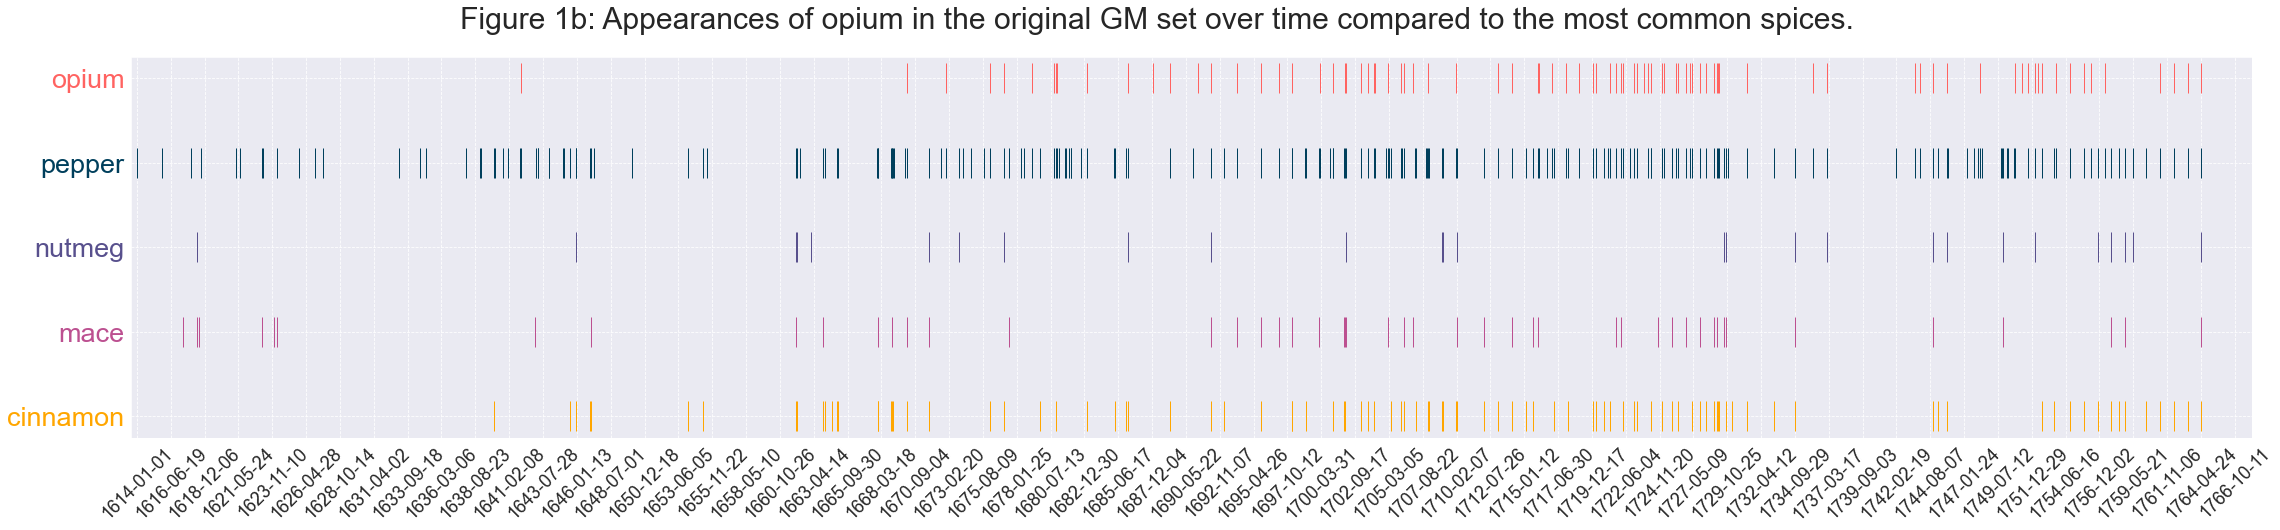

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns # to make things beautiful

target_commodities = ['opium', 'peper','nootmuskaat','foelie', 'kaneel']

fig = plt.figure(figsize=(38, 7))
sns.set_style('darkgrid', {'grid.linestyle': '--'})

kleuren = sns.color_palette('''#ff6361
#003f5c
#58508d
#bc5090
#ffa600'''.split('\n')) # https://www.learnui.design/tools/data-color-picker.html#palette


for i, commodity in enumerate(target_commodities):
    plt.plot(appearances[commodity], [i] * len(appearances[commodity]), '|', markersize=30,
                    color=kleuren[i])
    
graph = plt.gca()

graph.set_yticks(range(0,len(target_commodities)))
translated_commodities = ['opium','pepper','nutmeg','mace','cinnamon']

graph.set_yticklabels(translated_commodities,fontsize=27)
miny, nexty, *_, maxy = graph.get_yticks() # get the first two and last y-tick positions
epsy = (nexty - miny) / 4  # compute half the y-tick interval (for example)
graph.set_ylim(miny-epsy,maxy+epsy) # adjust the limits
graph.invert_yaxis()
for ytick, colour in zip(graph.get_yticklabels(), kleuren):
    ytick.set_color(colour) # labels are also coloured

graph.set_xticks(range(0, delta.days+450, 900))
graph.set_xticklabels([str(first_date+datetime.timedelta(days)) for days in range(0, delta.days+450, 900)],
                            rotation=45,fontsize=18)
minx, nextx, *_, maxx = graph.get_xticks() 
epsx = (nextx - minx) / 6  
graph.set_xlim(minx-epsx, maxx+epsx*3)

fig.suptitle('Figure 1b: Appearances of opium in the original GM set over time compared to the most common spices.',
         fontsize=30)
# plt.tight_layout()
plt.savefig('plots/opium_and_spices_latest.png',bbox_inches="tight")